In [1]:
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt

In [2]:
def a_star_shortest_path(field_init, init_point, destination_point, diags=False):
    field = np.copy(field_init)
    field[field > 1] = 0

    A_x, A_y = init_point[0], init_point[1]
    B_x, B_y = destination_point[0], destination_point[1]
    field[A_x][A_y] = 0
    field[B_x][B_y] = 0

    g_function = np.zeros(np.array(field).shape)  # g(x) function for all cells (-1 - function not calculated yet)
    g_function -= 1
    g_function = g_function.astype(int)

    h_function = np.zeros(np.array(field).shape)  # function h(x) for all cells (-1 - function not calculated yet)
    h_function -= 1
    h_function = g_function.astype(int)

    parents_X = np.zeros(
        np.array(field).shape)  # X-coordinate of the parent cell to restore the response (-1 - no parent defined)
    parents_X -= 1
    parents_X = parents_X.astype(int)

    parents_Y = np.zeros(
        np.array(field).shape)  # Y-coordinate of the parent cell to restore the answer (-1 - parent is not defined)
    parents_Y -= 1
    parents_Y = parents_Y.astype(int)

    open_list = [(A_x, A_y)]  # open list
    closed_list = set()  # closed list

    g_function[A_x][A_y] = 0  # the distance from the original cell to itself is zero
    h_function[A_x][A_y] = 10 * (
                abs(B_x - A_x) + abs(B_y - A_y))  # Manhattan distance from source cell to destination multiplied by 10

    while len(open_list) > 0:

        max_index = -1
        min_value = 1E6

        for k in range(len(open_list)):  # select the cell with the minimum function value f(x) = g(x) + h(x)
            if g_function[open_list[k][0]][open_list[k][1]] + h_function[open_list[k][0]][open_list[k][1]] < min_value:
                min_value = g_function[open_list[k][0]][open_list[k][1]] + h_function[open_list[k][0]][open_list[k][1]]
                max_index = k

        cur_point = open_list[max_index]

        if cur_point[0] == B_x and cur_point[1] == B_y:  # we have reached our destination
            break

        open_list.pop(max_index)

        for x in range(-1, 2):
            for y in range(-1, 2):  # loop through all neighbors
                if abs(x) + abs(y) == 0:  # you can't go from cell to yourself
                    continue
                if abs(x) + abs(y) > 1 and not diags:  # cannot walk diagonally if diags=False
                    continue
                new_point_X = cur_point[0] + x
                new_point_Y = cur_point[1] + y
                if new_point_X < 0 or new_point_X >= g_function.shape[0] or new_point_Y < 0 or new_point_Y >= \
                        g_function.shape[1]:  # cell out of bounds
                    continue
                if field[new_point_X][new_point_Y] != 0:  # wall
                    continue
                if (new_point_X, new_point_Y) in open_list or (
                new_point_X, new_point_Y) in closed_list:  # we've already been here
                    continue

                # if we still got here, update the values ​​of the functions and the parent cell
                g_function[new_point_X][new_point_Y] = g_function[cur_point[0]][cur_point[1]] + 10  # always add 10
                if abs(x) + abs(y) > 1:
                    g_function[new_point_X][new_point_Y] += 4  # if we came diagonally, add 4 more, i.e. 14 in total

                # Manhattan distance to end cell multiplied by 10
                h_function[new_point_X][new_point_Y] = 10 * (abs(B_x - new_point_X) + abs(B_y - new_point_Y))

                parents_X[new_point_X][new_point_Y] = cur_point[0]
                parents_Y[new_point_X][new_point_Y] = cur_point[1]

                open_list.append((new_point_X, new_point_Y))

        closed_list.add(cur_point)

    total_path = [(B_x, B_y)]  # restore the path

    cur_point = (B_x, B_y)
    while cur_point != (A_x, A_y):
        if cur_point[0] == -1 or cur_point[1] == -1:
            return []
        next_point = (parents_X[cur_point[0]][cur_point[1]], parents_Y[cur_point[0]][cur_point[1]])
        total_path.append(next_point)
        cur_point = next_point

    total_path = list(reversed(total_path))
    return total_path

In [3]:
def generate_position(field_height, fiend_width, walls_count, enemies_smart):
    field = np.zeros(shape=field_height * fiend_width)
    field[:walls_count] = 1
    field[walls_count: walls_count + enemies_smart] = 2
    field[walls_count + enemies_smart] = 3
    field[walls_count + enemies_smart + 1] = 4

    while True:
        np.random.shuffle(field)
        field_reshaped = field.reshape((field_height, fiend_width))

        res_st = np.where(field_reshaped == 3)
        res_end = np.where(field_reshaped == 4)

        sh_path = a_star_shortest_path(field_reshaped, (res_st[0][0], res_st[1][0]), (res_end[0][0], res_end[1][0]))
        if len(sh_path) > 0:
            return field_reshaped

In [4]:
class Game:

    def __init__(self, height, width, walls_count, enemies_count, depth=5):
        self.field = generate_position(height, width, walls_count, enemies_count)
        self.agent_active = 0
        self.label_list = ['free', 'wall', 'enemies_pos', 'pacman_pos', 'end_pos']
        self.depth = depth
        self.enemies_count = enemies_count

        res = np.where(self.field == len(self.label_list) - 1)
        self.end_position = tuple(zip(res[0], res[1]))[0]
        self.field[self.end_position[0]][self.end_position[1]] = 0

    def get_coord_dict(self, position=None):
        coord_dict = defaultdict(list)

        if position is None:
            position = self.field

        for k in range(2, len(self.label_list)):
            res = np.where(self.field == k)
            for t in list(zip(res[0], res[1])):
                coord_dict[self.label_list[k]].append(t)

        return coord_dict

    def dist_to_smart(self, position=None):

        if position is None:
            position = self.field

        coord_dict = self.get_coord_dict(position)
        start_coords = coord_dict['pacman_pos'][0]

        dist_to_enemies_smart = 1E6

        for k in coord_dict['enemies_pos']:
            sh_path_to_smart = a_star_shortest_path(position, start_coords, k)
            cur_dist = len(sh_path_to_smart) - 1
            #cur_dist = abs(start_coords[0] - k[0]) + abs(start_coords[1] - k[1])
            dist_to_enemies_smart = min(dist_to_enemies_smart, cur_dist)

        return dist_to_enemies_smart

    def evaluate_position(self, position=None, agent_active=None):

        if position is None:
            position = self.field

        if agent_active is None:
            agent_active = self.agent_active

        game_over = self.is_game_over(position, agent_active)
        if game_over != 0:
            return game_over

        coord_dict = self.get_coord_dict(position)
        dist_to_enemies_smart = self.dist_to_smart(position)

        start_coords = coord_dict['pacman_pos'][0]
        end_coords = self.end_position

        #sh_path_to_end = a_star_shortest_path(position, start_coords, end_coords)
        #dist_to_end_pos = len(sh_path_to_end) - 1
        dist_to_end_pos = abs(start_coords[0] - end_coords[0]) + abs(start_coords[1] - end_coords[1])

        #return dist_to_enemies_smart - dist_to_end_pos
        return dist_to_enemies_smart - 10 * dist_to_end_pos

    def get_legal_moves(self, position=None, agent_active=None):

        if position is None:
            position = self.field

        if agent_active is None:
            agent_active = self.agent_active

        if agent_active == 0:
            cur_key = 'pacman_pos'
        else:
            cur_key = 'enemies_pos'

        coord_dict = self.get_coord_dict(position)
        dirs_deltas = [(+0, -1), (+1, +0), (+0, +1), (-1, +0)]

        cur_pos = coord_dict[cur_key][max(0, agent_active - 1)]
        cur_moves = []

        for d in dirs_deltas:
            next_pos_X, next_pos_Y = cur_pos[0] + d[0], cur_pos[1] + d[1]
            if next_pos_X < 0 or next_pos_X >= len(position):
                continue
            if next_pos_Y < 0 or next_pos_Y >= len(position[0]):
                continue
            if position[next_pos_X][next_pos_Y] not in (1, 2):
                cur_moves.append((next_pos_X, next_pos_Y))

        return cur_pos, cur_moves

    def is_game_over(self, position=None, agent_active=None):

        if position is None:
            position = self.field

        if agent_active is None:
            agent_active = self.agent_active

        coord_dict = self.get_coord_dict(position)
        pacman_coords = coord_dict['pacman_pos'][0]

        cur_pos, legal_moves = self.get_legal_moves(position, agent_active)
        if agent_active == 0 and self.end_position in legal_moves:
            return 1E6
        if agent_active > 0 and pacman_coords in legal_moves:
            return -1E6

        return 0

    def maximizer(self, agent, depth, game_state, a, b):  # maximizer function
        v = float("-inf")

        cur_pos, new_positions = self.get_legal_moves(game_state, agent)
        for new_pos in new_positions:
            new_game_state = np.copy(game_state)
            new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
            new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]

            v = max(v, self.alphabetaprune(1, depth, new_game_state, a, b))
            if v > b:
                return v
            a = max(a, v)
        return v

    def minimizer(self, agent, depth, game_state, a, b):  # minimizer function
        v = float("inf")

        next_agent = agent + 1  # calculate the next agent and increase depth accordingly.
        if self.enemies_count <= next_agent:
            next_agent = 0

        if next_agent == 0:
            depth += 1

        cur_pos, new_positions = self.get_legal_moves(game_state, agent)
        for new_pos in new_positions:
            new_game_state = np.copy(game_state)
            new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
            new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]

            v = min(v, self.alphabetaprune(next_agent, depth, new_game_state, a, b))
            if v < a:
                return v
            b = min(b, v)
        return v

    def alphabetaprune(self, agent, depth, game_state, a, b):
        if self.is_game_over(game_state,
                             agent) != 0 or depth == self.depth:  # return the utility in case the defined depth is reached or the game is won/lost.
            return self.evaluate_position(game_state, agent)

        if agent == 0:  # maximize for pacman
            return self.maximizer(agent, depth, game_state, a, b)
        else:  # minimize for enemies
            return self.minimizer(agent, depth, game_state, a, b)

    def expectimax(self, agent, depth, game_state):
        if self.is_game_over(game_state,
                             agent) != 0 or depth == self.depth:  # return the utility in case the defined depth is reached or the game is won/lost.
            return self.evaluate_position(game_state)

        if agent == 0:  # maximize for pacman
            v = float("-inf")
            cur_pos, new_positions = self.get_legal_moves(game_state, agent)
            for new_pos in new_positions:
                new_game_state = np.copy(game_state)
                new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
                new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]
                v = max(v, self.expectimax(1, depth, new_game_state))
            return v
        else:
            next_agent = agent + 1
            if self.enemies_count <= next_agent:
                next_agent = 0

            if next_agent == 0:
                depth += 1

            v = 0
            cur_pos, new_positions = self.get_legal_moves(game_state, agent)
            for new_pos in new_positions:
                new_game_state = np.copy(game_state)
                new_game_state[cur_pos[0]][cur_pos[1]] = game_state[new_pos[0]][new_pos[1]]
                new_game_state[new_pos[0]][new_pos[1]] = game_state[cur_pos[0]][cur_pos[1]]
                v += self.expectimax(next_agent, depth, new_game_state)
            return v / len(new_positions)

    def make_pacman_move(self, expectimax):
        utility = float("-inf")
        move = None
        alpha = float("-inf")
        beta = float("inf")

        cur_pos, new_positions = self.get_legal_moves(self.field, 0)
        for new_pos in new_positions:
            new_game_state = np.copy(self.field)
            new_game_state[cur_pos[0]][cur_pos[1]] = self.field[new_pos[0]][new_pos[1]]
            new_game_state[new_pos[0]][new_pos[1]] = self.field[cur_pos[0]][cur_pos[1]]

            if expectimax:
                enemies_value = self.expectimax(1, 0, new_game_state)
            else:
                enemies_value = self.alphabetaprune(1, 0, new_game_state, alpha, beta)

            if enemies_value > utility:
                utility = enemies_value
                move = (cur_pos, new_pos)
                alpha = max(alpha, utility)

        if move is None:
            move = (cur_pos, cur_pos)

        return move

    def play_one_move(self, expectimax):

        cur_pos, new_pos = self.make_pacman_move(expectimax)
        if new_pos == self.end_position:
            return 1E6

        new_game_state = np.copy(self.field)
        new_game_state[cur_pos[0]][cur_pos[1]] = self.field[new_pos[0]][new_pos[1]]
        new_game_state[new_pos[0]][new_pos[1]] = self.field[cur_pos[0]][cur_pos[1]]

        self.field = new_game_state

        print('Pacman move: ' + str(cur_pos) + '->' + str(new_pos))

        if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
            new_game_state[self.end_position[0]][self.end_position[1]] = 4

        plt.figure(figsize=(10, 10))
        plt.imshow(new_game_state)
        plt.show()

        coord_dict = self.get_coord_dict()
        pacman_coords = coord_dict['pacman_pos'][0]
        enemies_coords = coord_dict['enemies_pos']

        new_game_state = np.copy(self.field)

        for k in range(self.enemies_count):
            cur_path_to_pacman = a_star_shortest_path(self.field, enemies_coords[k], pacman_coords)
            if len(cur_path_to_pacman) < 2 or self.field[cur_path_to_pacman[1][0]][cur_path_to_pacman[1][1]] in (1, 2):
                best_move = enemies_coords[k]
            elif len(cur_path_to_pacman) == 2:
                return -1E6
            else:
                best_move = cur_path_to_pacman[1]

            new_game_state = np.copy(self.field)
            new_game_state[enemies_coords[k][0]][enemies_coords[k][1]] = self.field[best_move[0]][best_move[1]]
            new_game_state[best_move[0]][best_move[1]] = self.field[enemies_coords[k][0]][enemies_coords[k][1]]
            self.field = new_game_state

            print('Enemy {} move: '.format(k + 1) + str(enemies_coords[k]) + '->' + str(best_move))

        if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
            new_game_state[self.end_position[0]][self.end_position[1]] = 4

        plt.figure(figsize=(10, 10))
        plt.imshow(new_game_state)
        plt.show()

        return 0

    def play(self, expectimax=False):

        print('Initial position:')

        new_game_state = np.copy(self.field)
        if new_game_state[self.end_position[0]][self.end_position[1]] == 0:
            new_game_state[self.end_position[0]][self.end_position[1]] = 4

        plt.figure(figsize=(10, 10))
        plt.imshow(new_game_state)
        plt.show()

        for moves in range(50):
            is_game_over = self.play_one_move(expectimax)
            if is_game_over < 0:
                print('Enemies win.')
                return
            elif is_game_over > 0:
                print('Pacman wins!')
                return

        print('Draw after 50 moves!')

In [5]:
game = Game(10, 10, 15, 3, 2)

Initial position:


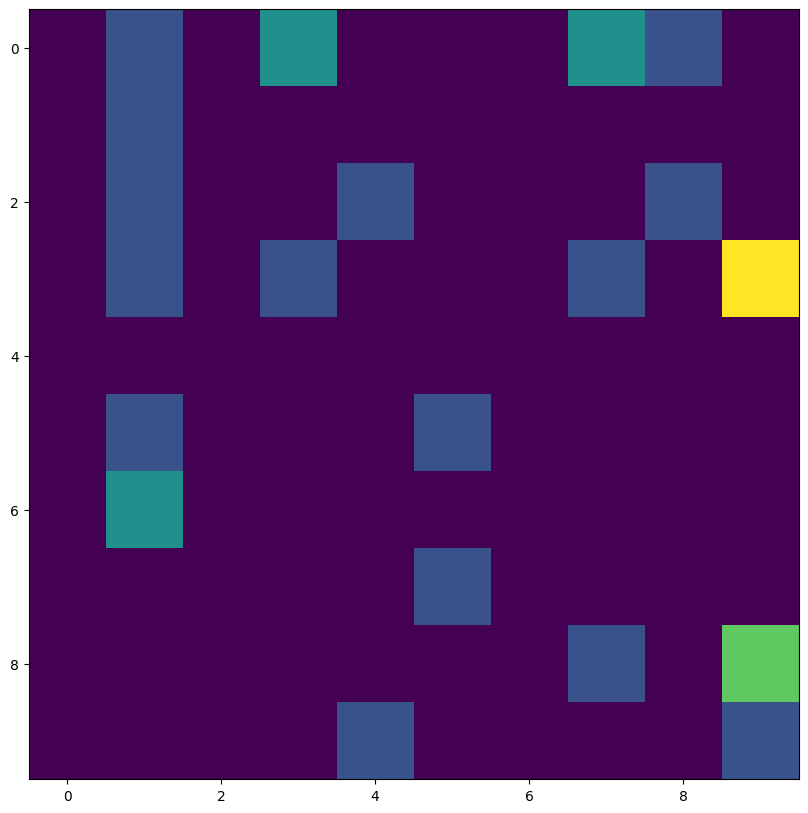

Pacman move: (8, 9)->(8, 8)


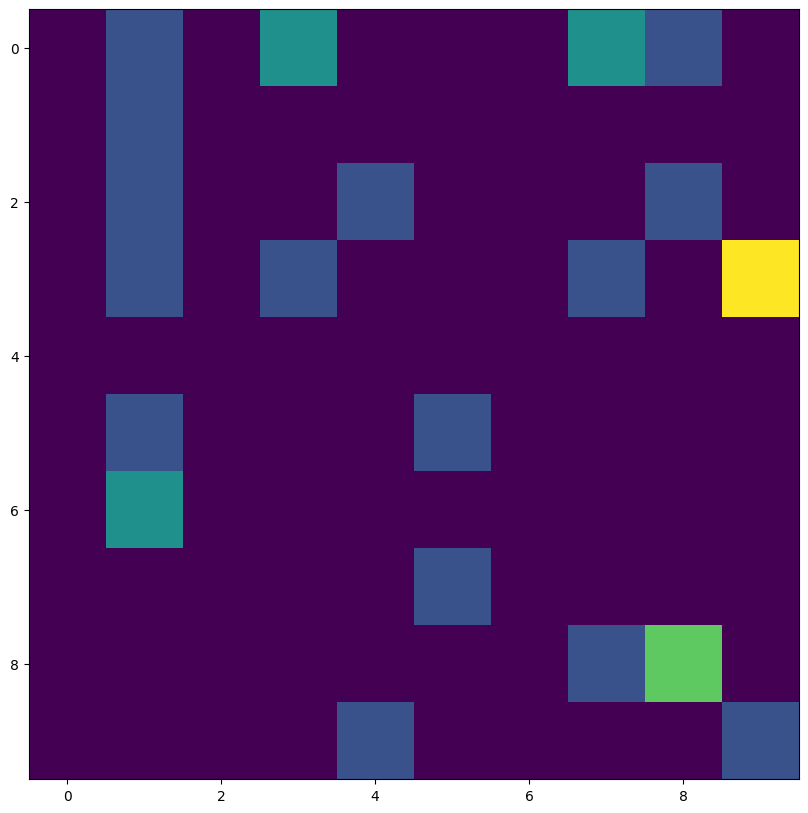

Enemy 1 move: (0, 3)->(0, 4)
Enemy 2 move: (0, 7)->(1, 7)
Enemy 3 move: (6, 1)->(6, 2)


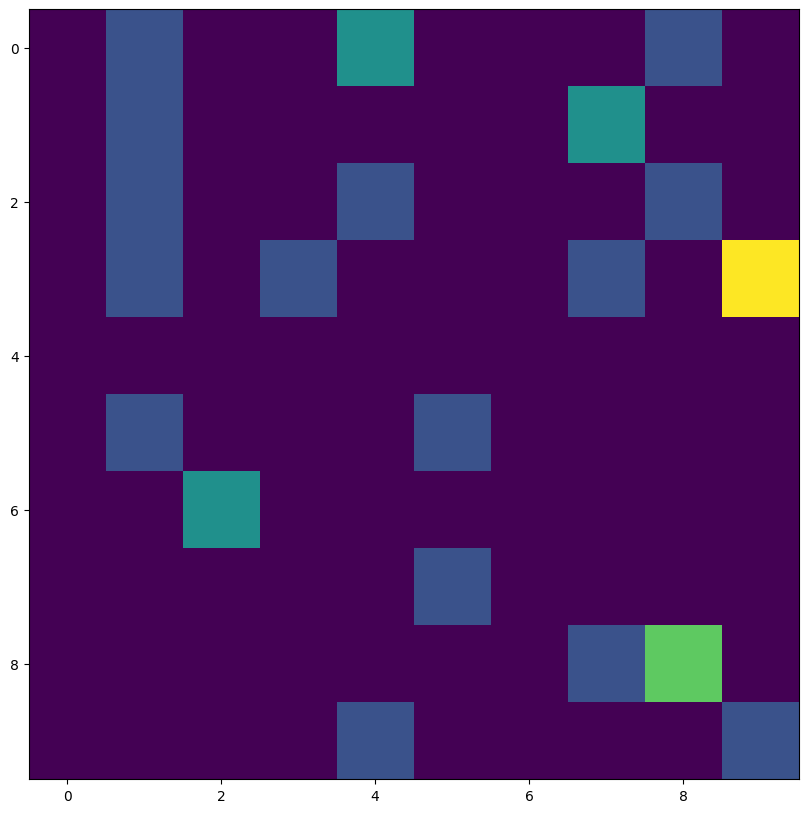

Pacman move: (8, 8)->(9, 8)


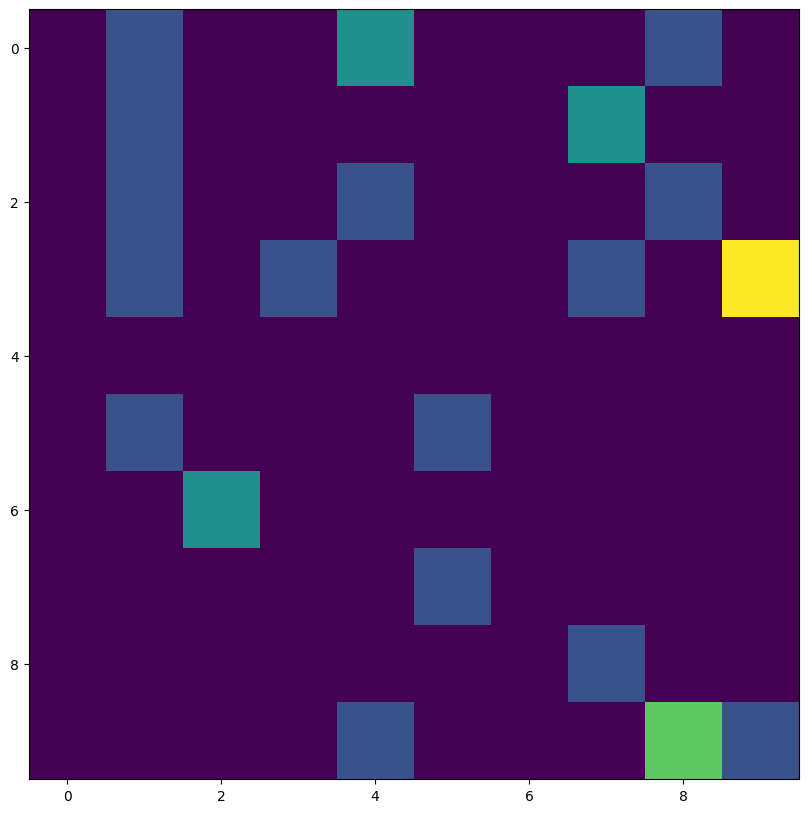

Enemy 1 move: (0, 4)->(0, 5)
Enemy 2 move: (1, 7)->(1, 8)
Enemy 3 move: (6, 2)->(6, 3)


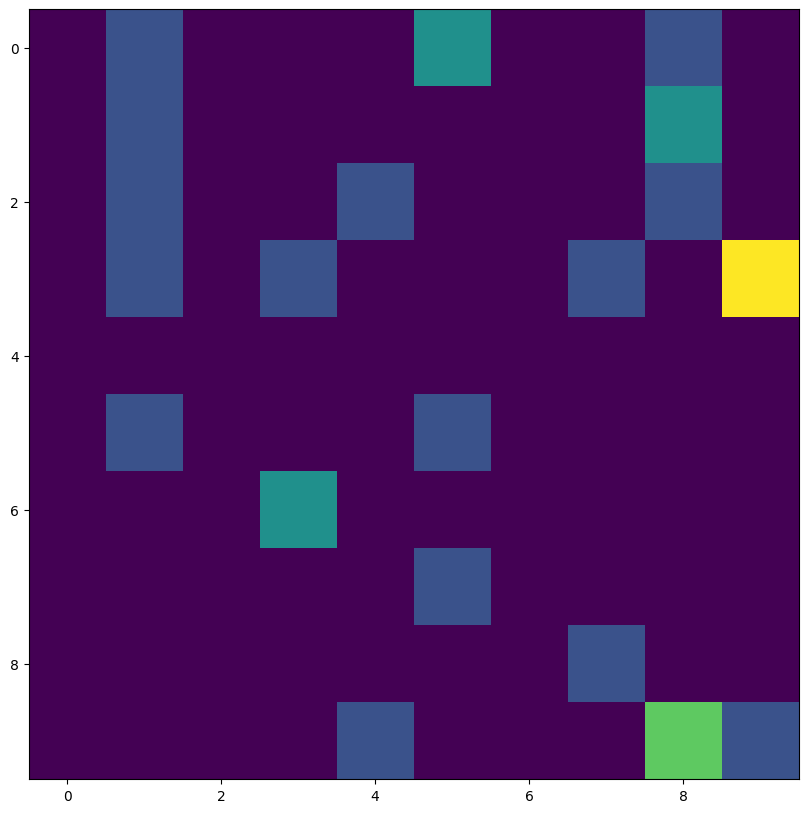

Pacman move: (9, 8)->(9, 7)


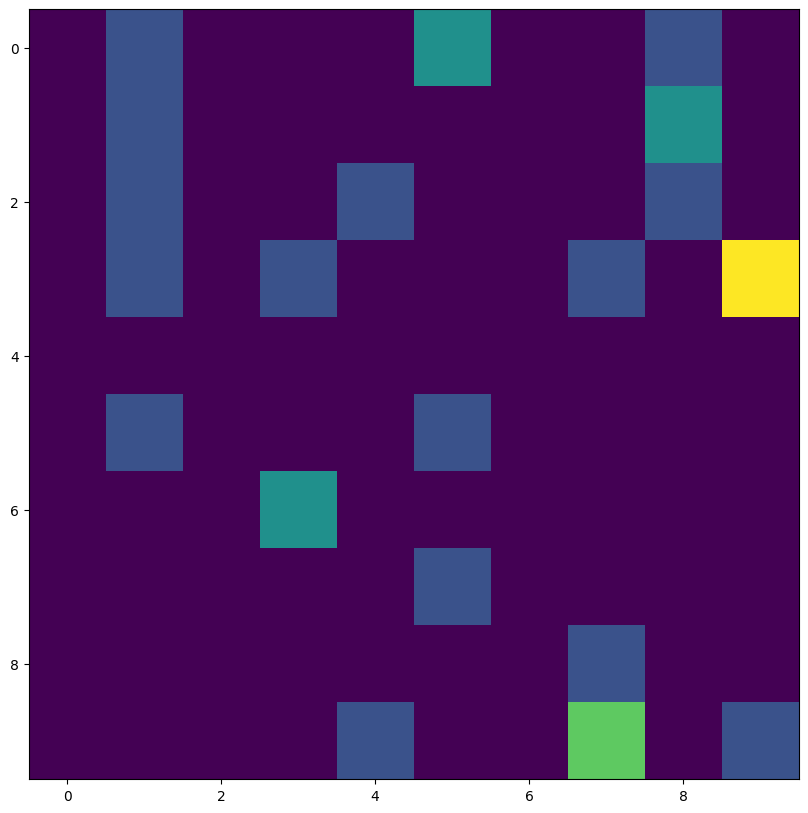

Enemy 1 move: (0, 5)->(0, 6)
Enemy 2 move: (1, 8)->(1, 7)
Enemy 3 move: (6, 3)->(6, 4)


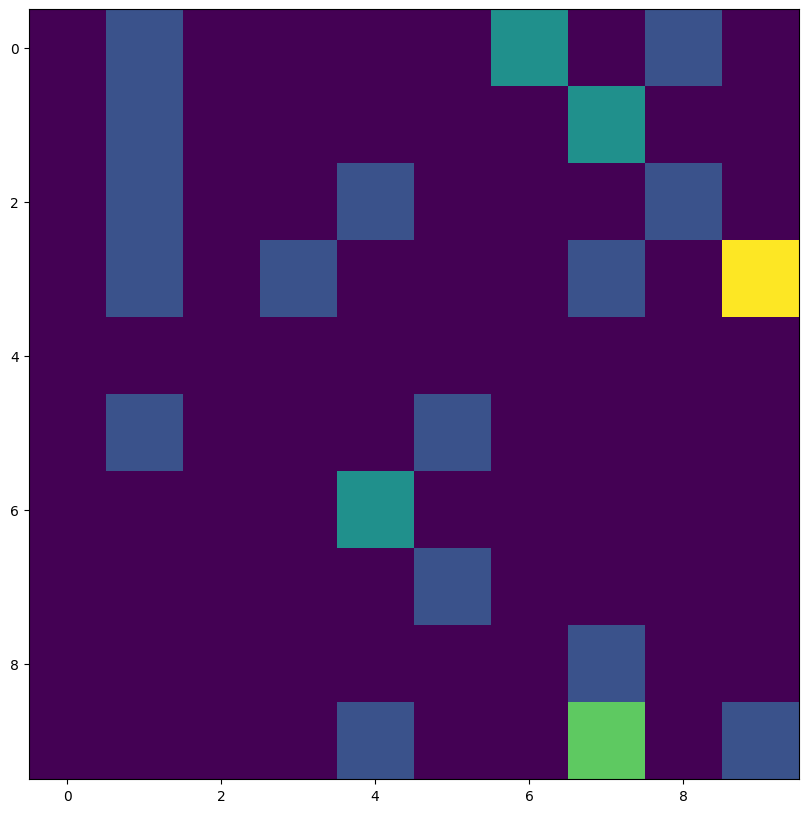

Pacman move: (9, 7)->(9, 6)


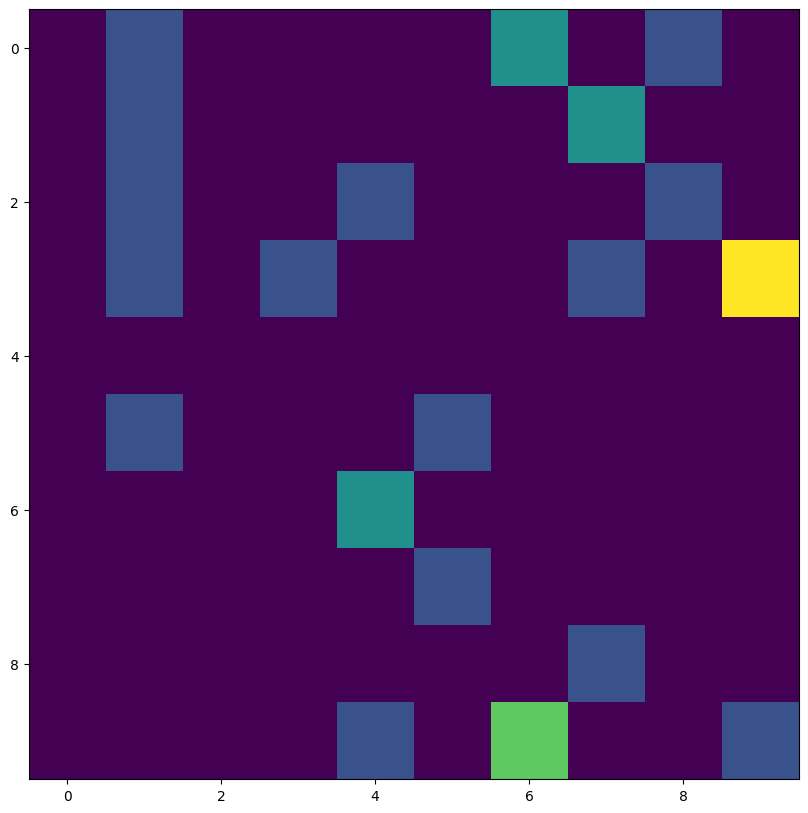

Enemy 1 move: (0, 6)->(1, 6)
Enemy 2 move: (1, 7)->(1, 7)
Enemy 3 move: (6, 4)->(6, 5)


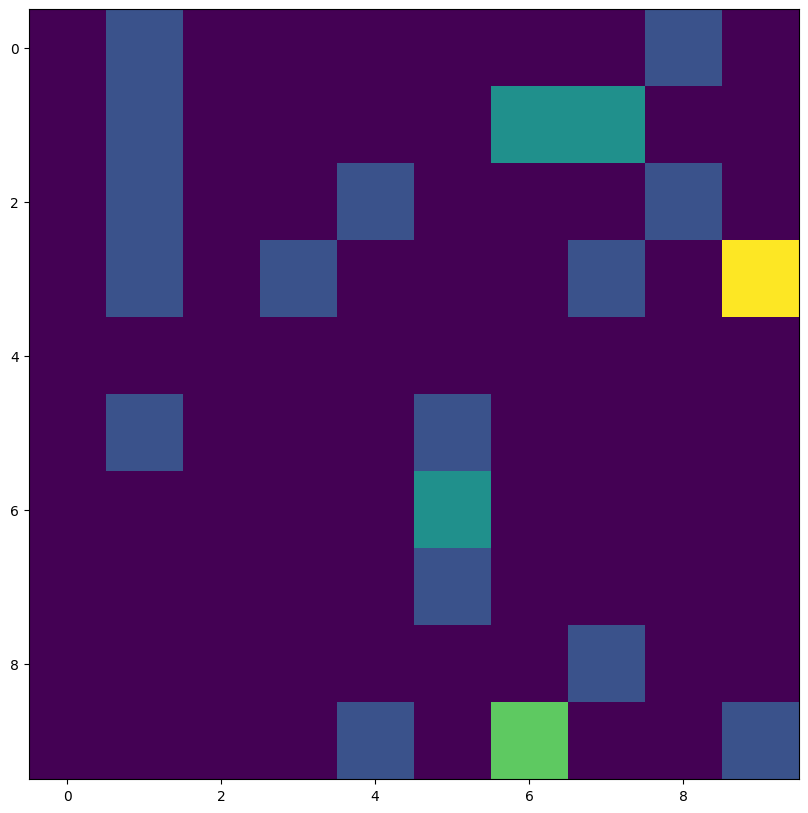

Pacman move: (9, 6)->(9, 5)


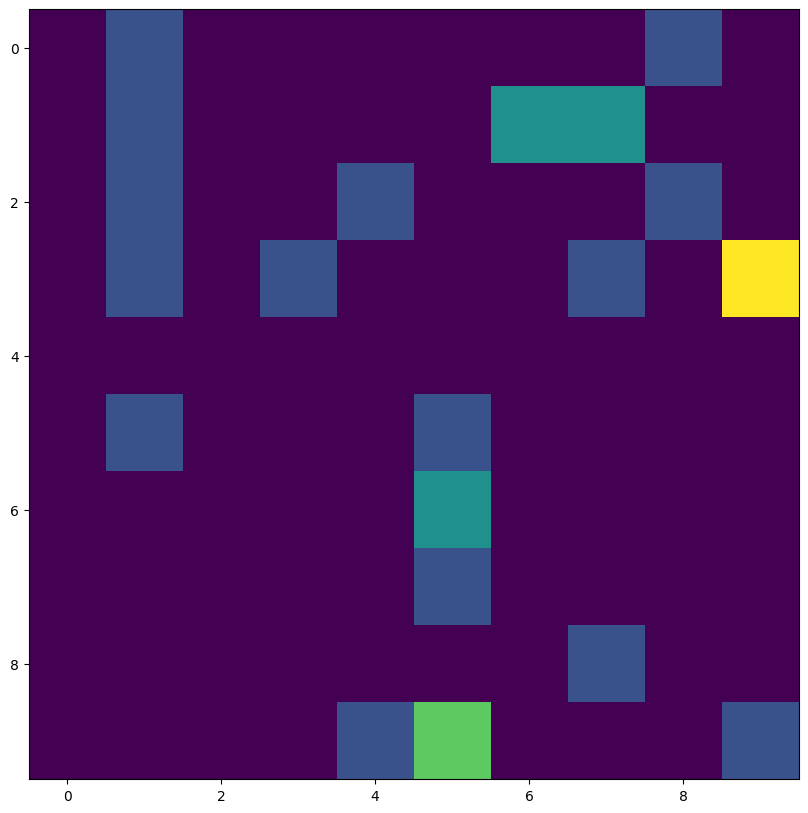

Enemy 1 move: (1, 6)->(2, 6)
Enemy 2 move: (1, 7)->(1, 6)
Enemy 3 move: (6, 5)->(6, 4)


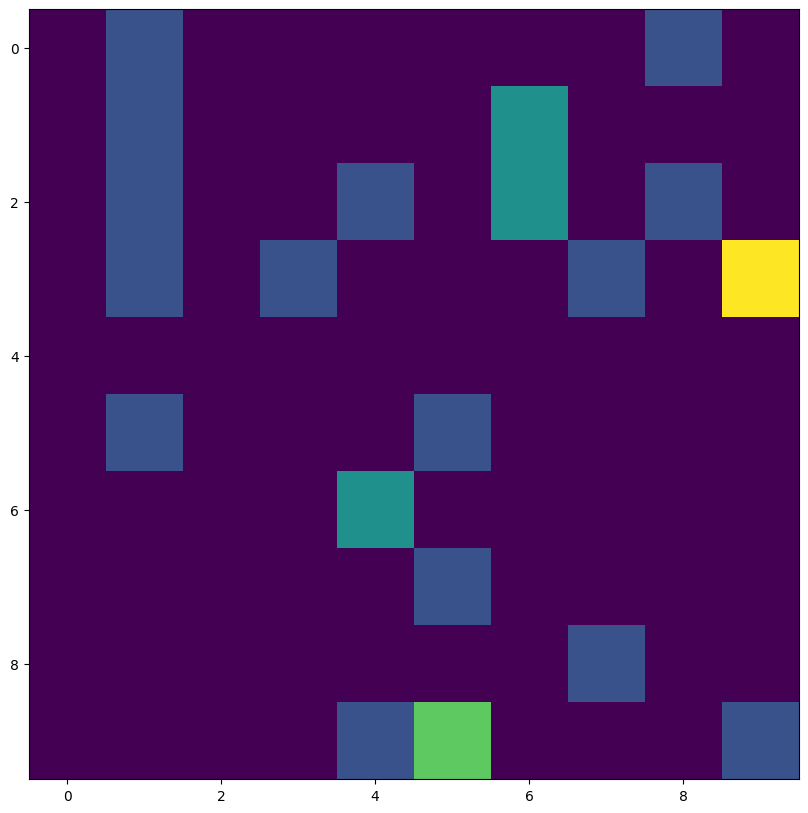

Pacman move: (9, 5)->(9, 6)


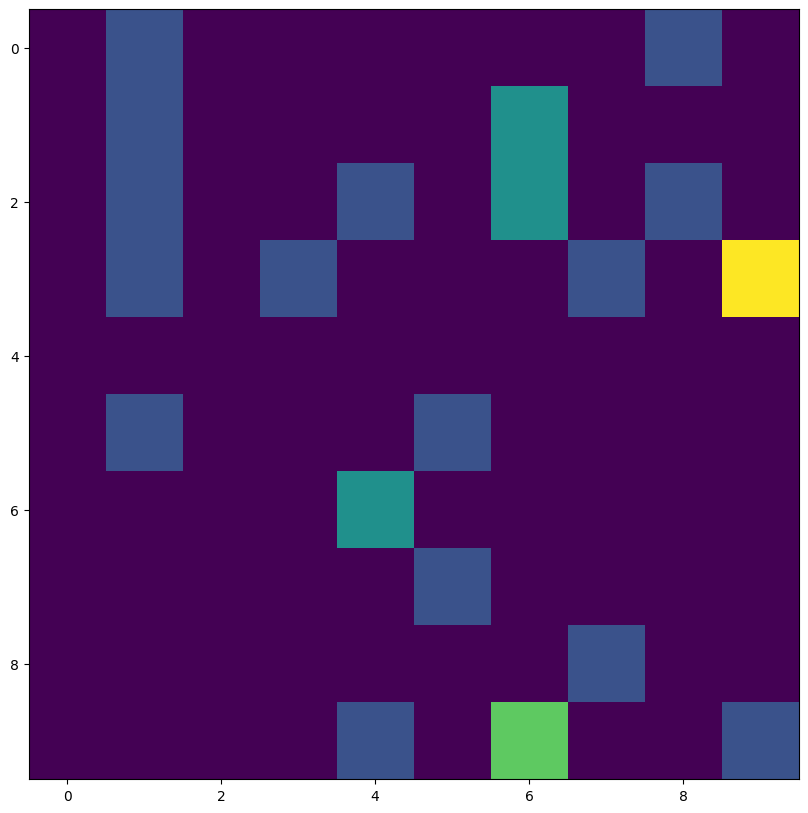

Enemy 1 move: (1, 6)->(1, 6)
Enemy 2 move: (2, 6)->(3, 6)
Enemy 3 move: (6, 4)->(6, 5)


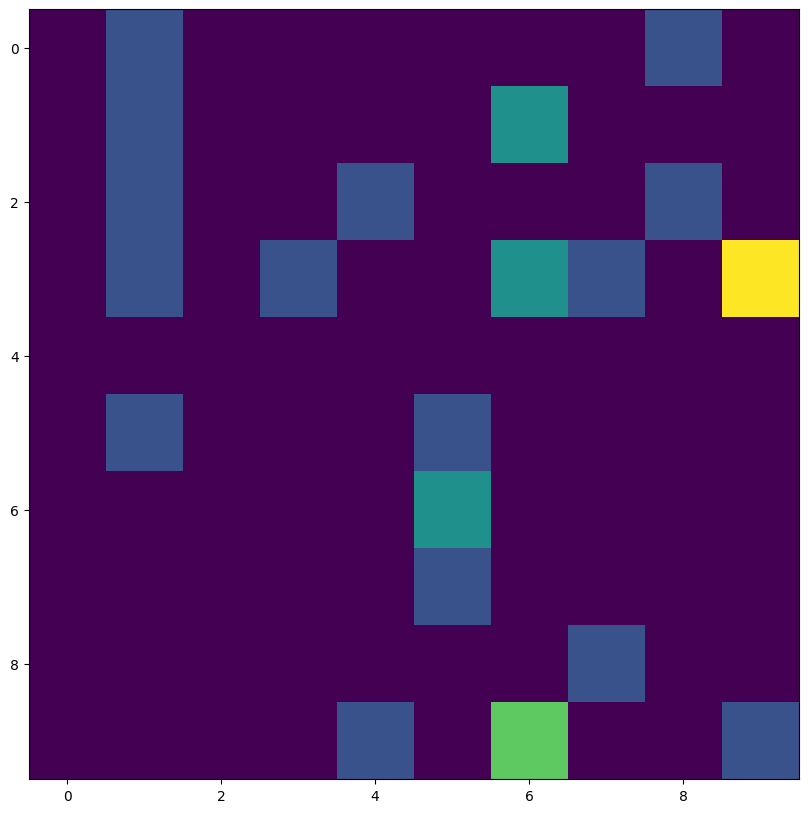

Pacman move: (9, 6)->(9, 5)


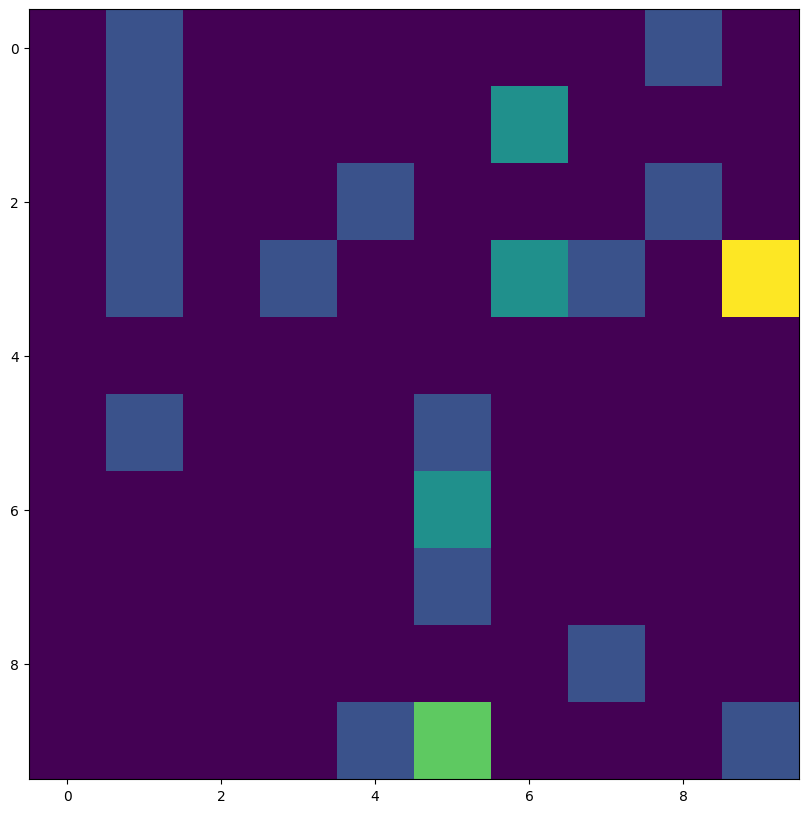

Enemy 1 move: (1, 6)->(2, 6)
Enemy 2 move: (3, 6)->(4, 6)
Enemy 3 move: (6, 5)->(6, 4)


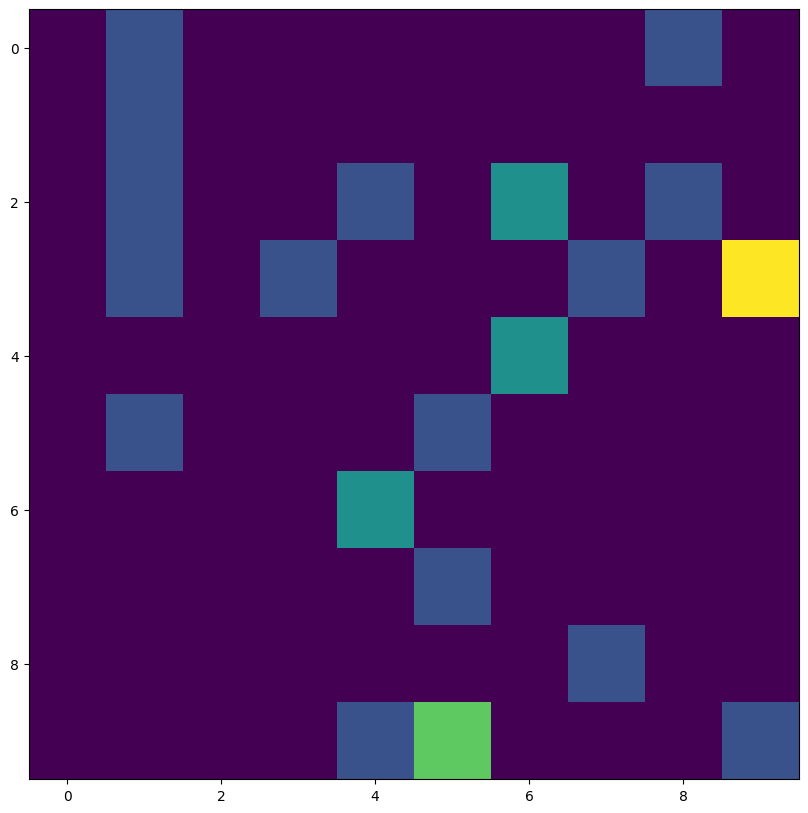

Pacman move: (9, 5)->(9, 6)


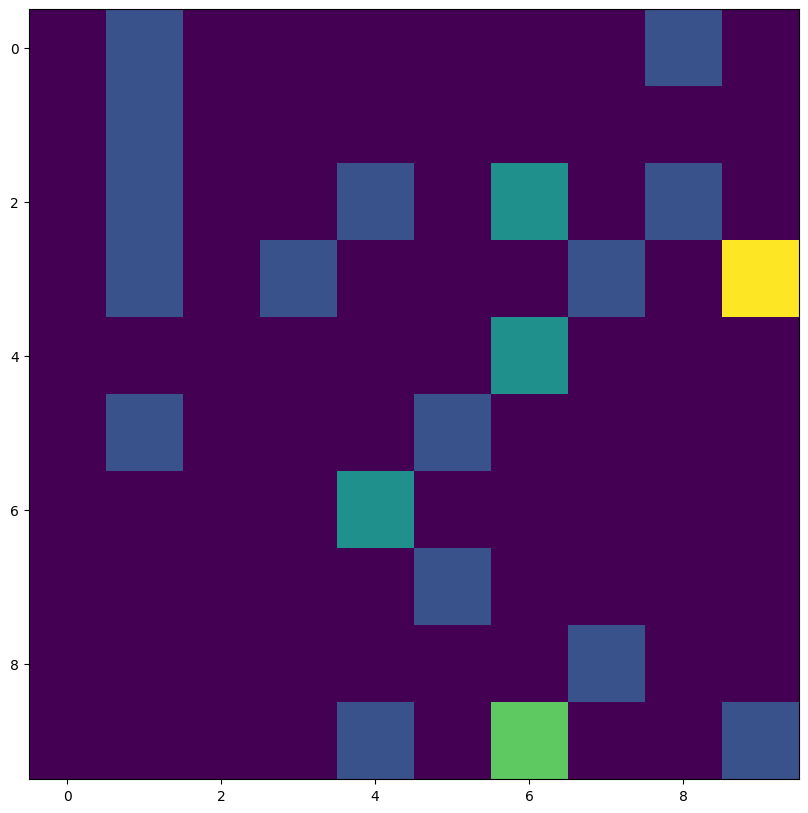

Enemy 1 move: (2, 6)->(3, 6)
Enemy 2 move: (4, 6)->(5, 6)
Enemy 3 move: (6, 4)->(6, 5)


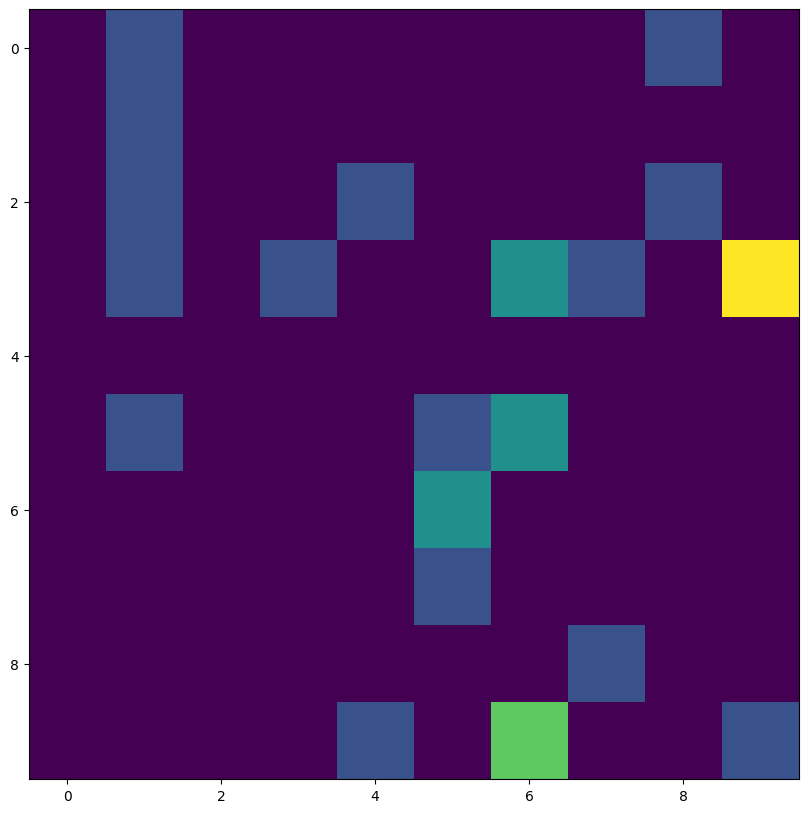

Pacman move: (9, 6)->(9, 5)


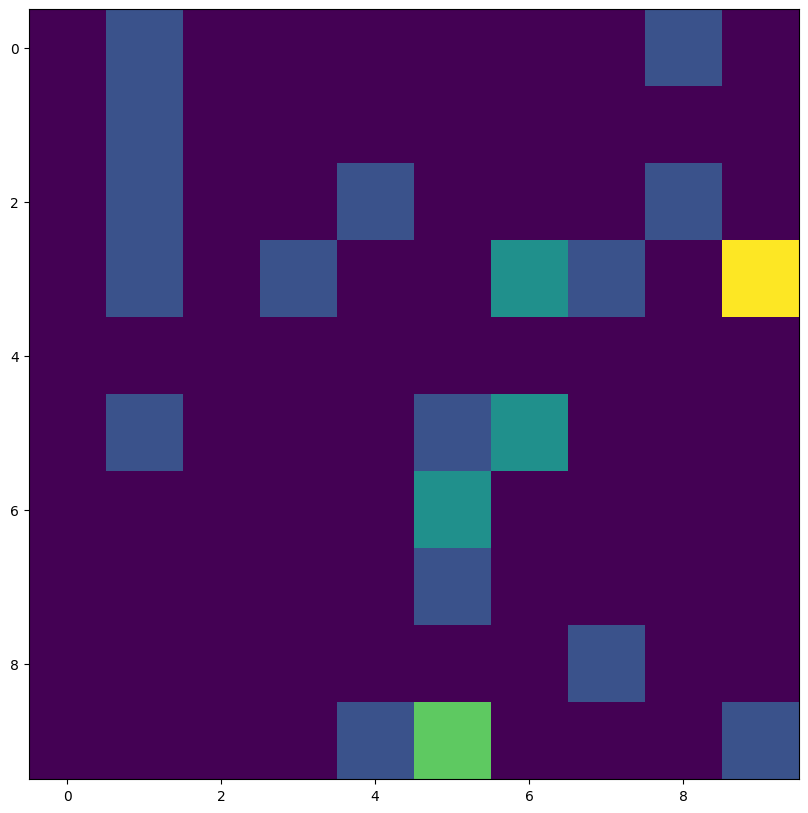

Enemy 1 move: (3, 6)->(4, 6)
Enemy 2 move: (5, 6)->(6, 6)
Enemy 3 move: (6, 5)->(6, 4)


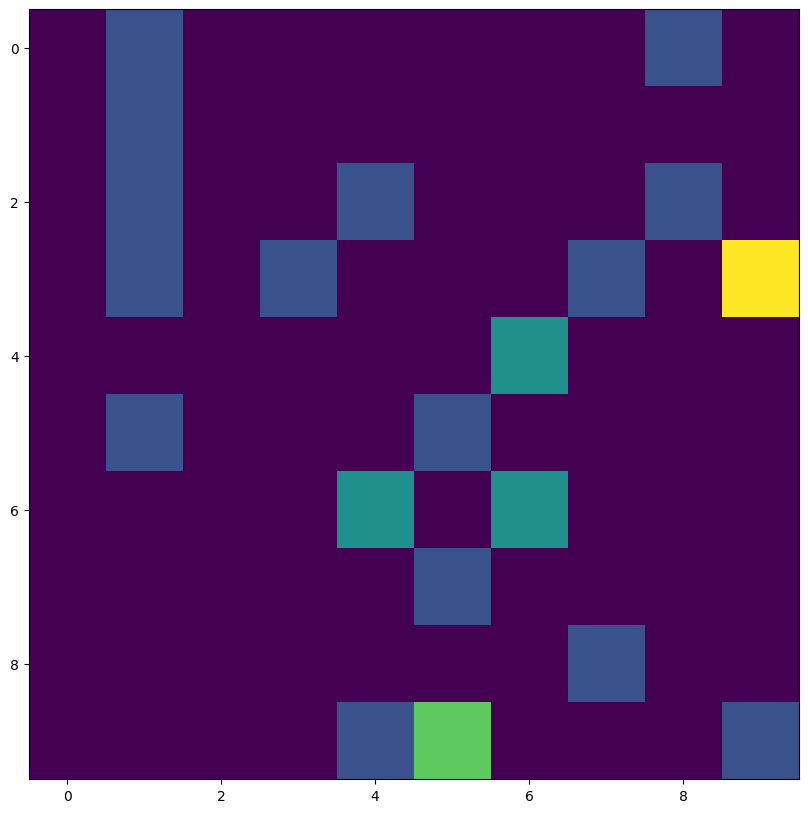

Pacman move: (9, 5)->(9, 6)


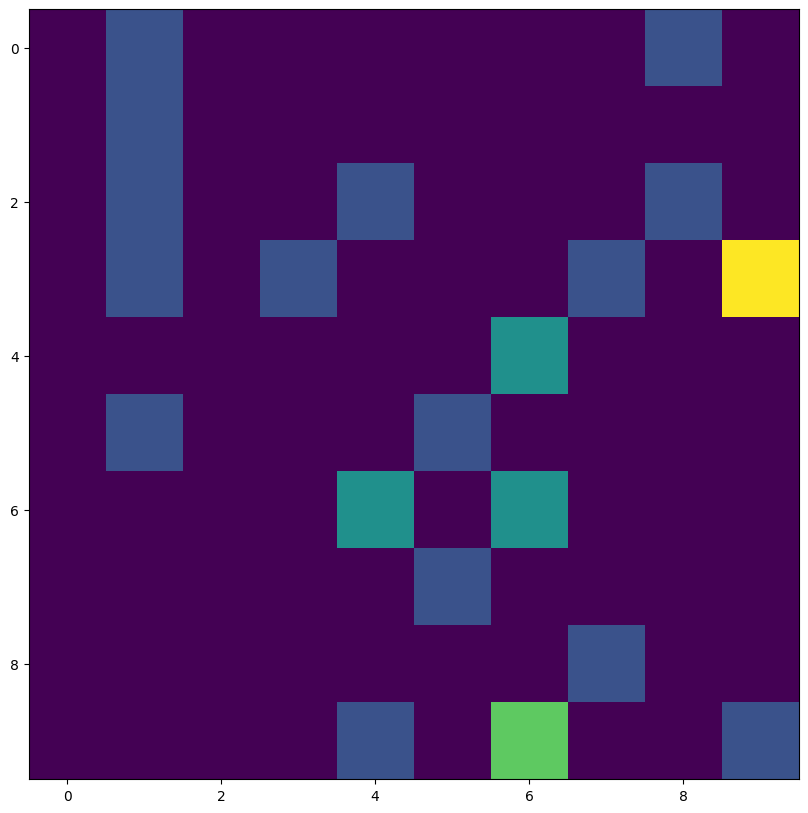

Enemy 1 move: (4, 6)->(5, 6)
Enemy 2 move: (6, 4)->(6, 5)
Enemy 3 move: (6, 6)->(7, 6)


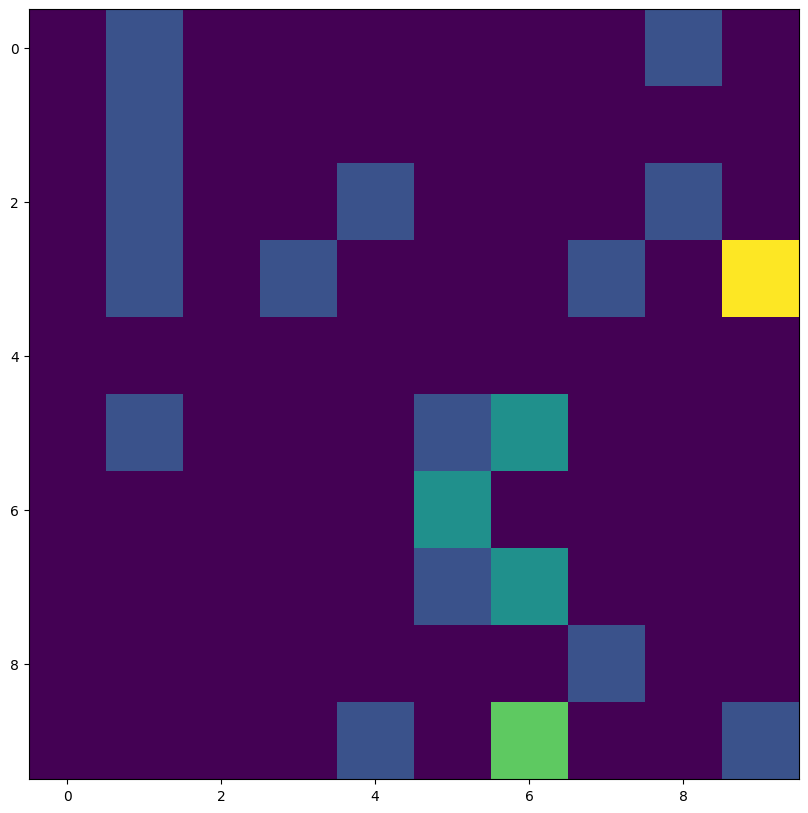

Pacman move: (9, 6)->(9, 5)


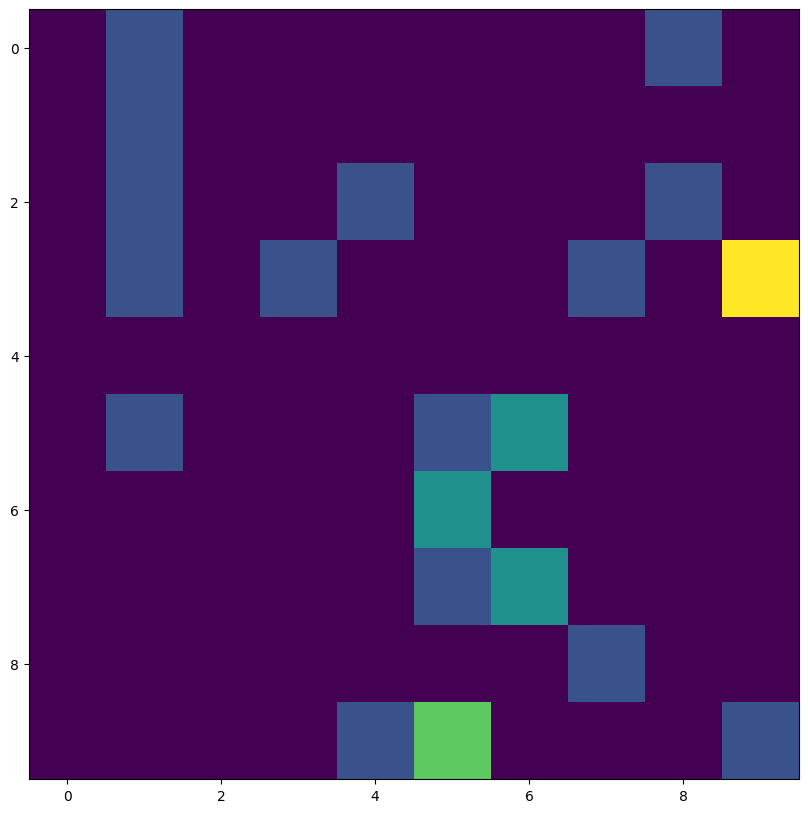

Enemy 1 move: (5, 6)->(6, 6)
Enemy 2 move: (6, 5)->(6, 4)
Enemy 3 move: (7, 6)->(8, 6)


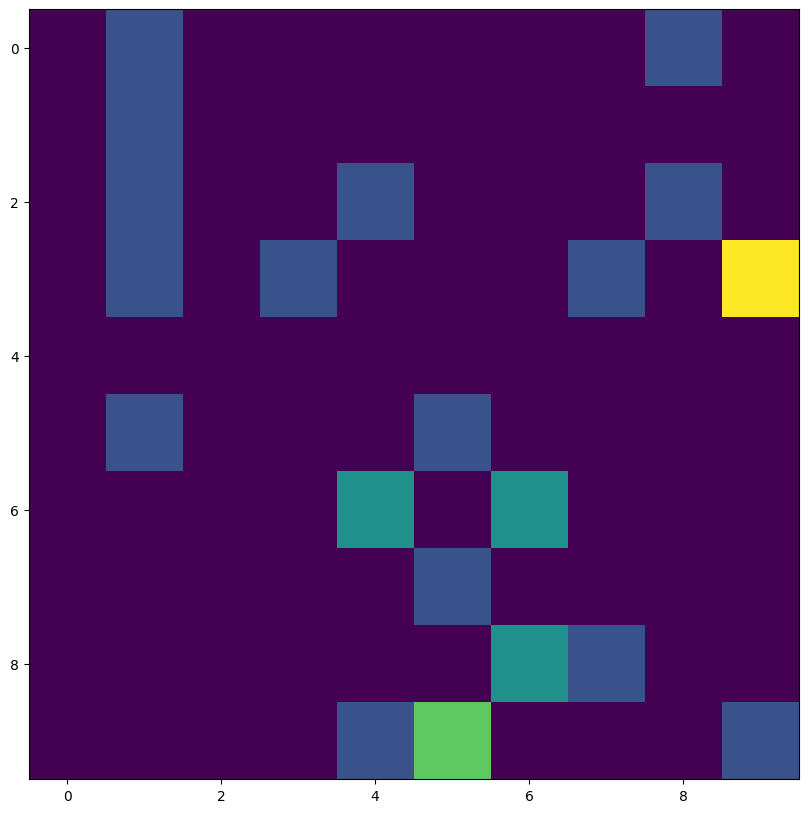

Pacman move: (9, 5)->(9, 6)


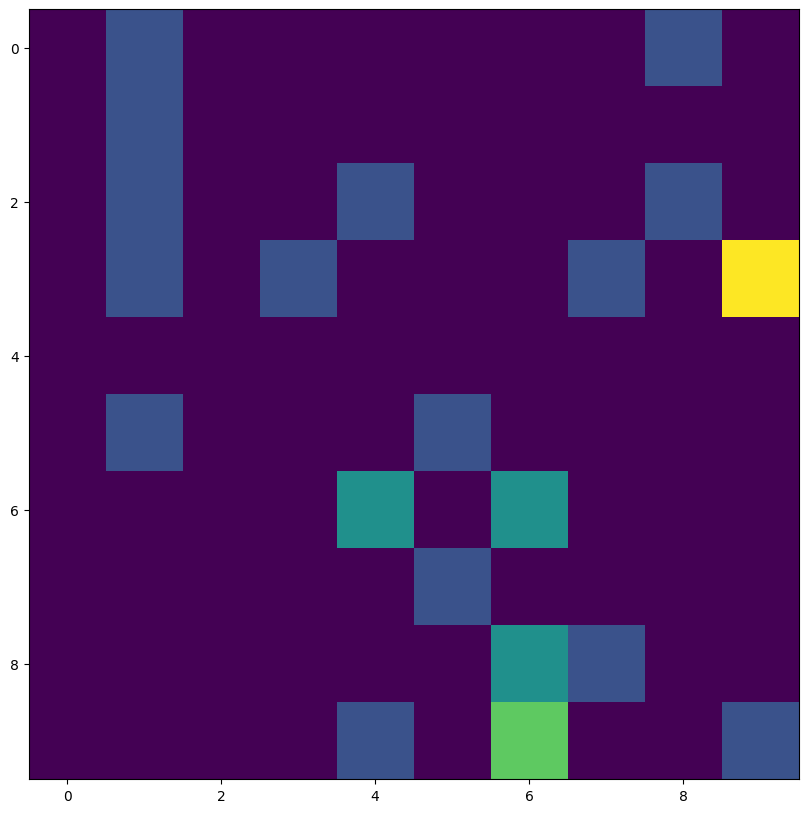

Enemy 1 move: (6, 4)->(6, 5)
Enemy 2 move: (6, 6)->(7, 6)
Enemies win.


In [6]:
game.play()

Initial position:


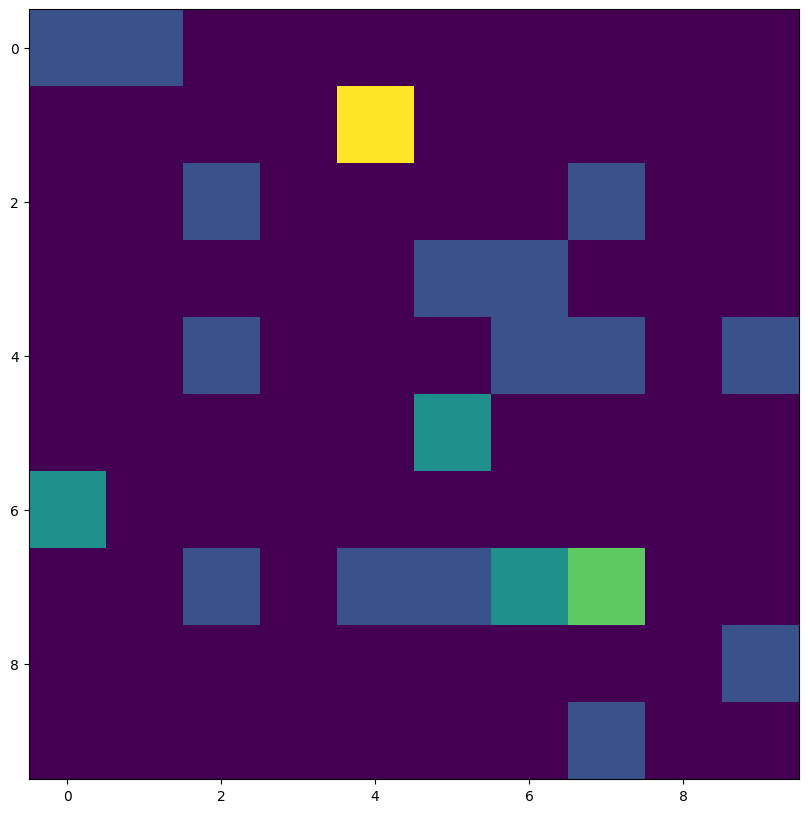

Pacman move: (7, 7)->(8, 7)


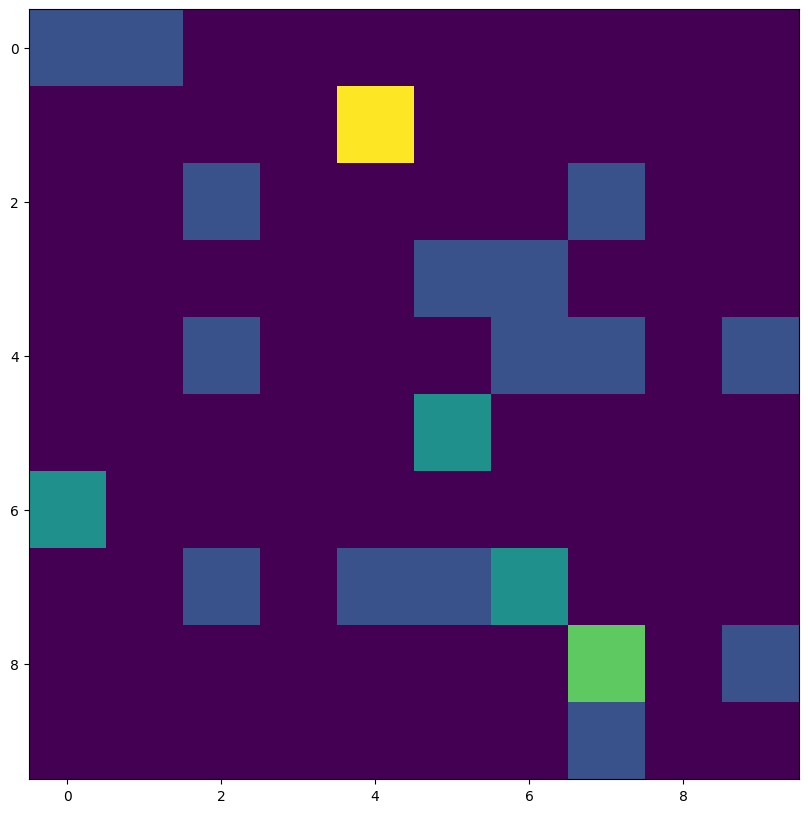

Enemy 1 move: (5, 5)->(5, 6)
Enemy 2 move: (6, 0)->(6, 1)
Enemy 3 move: (7, 6)->(7, 7)


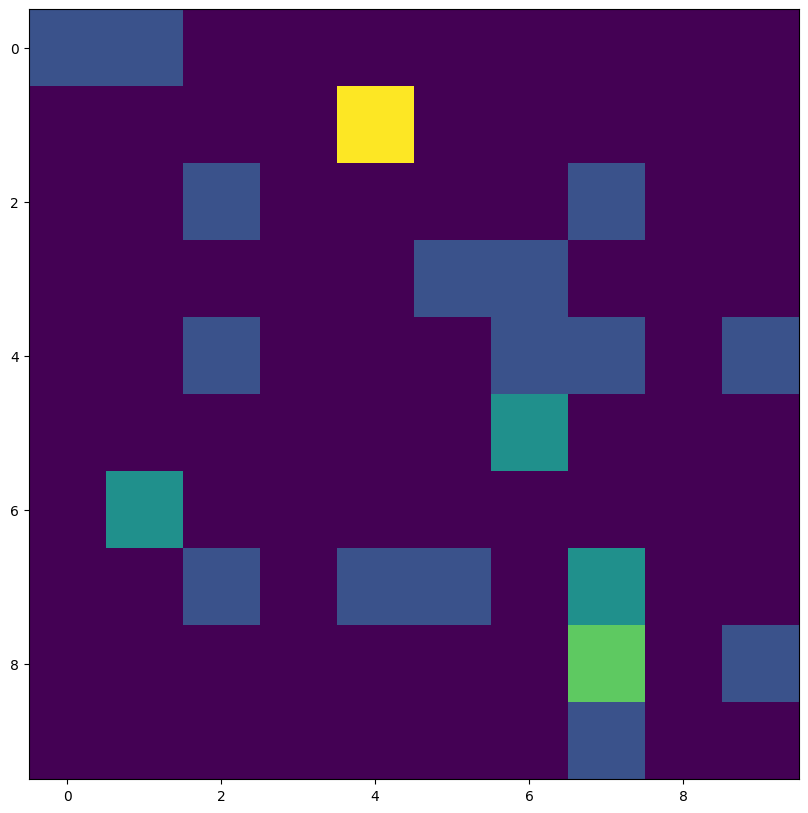

Pacman move: (8, 7)->(8, 6)


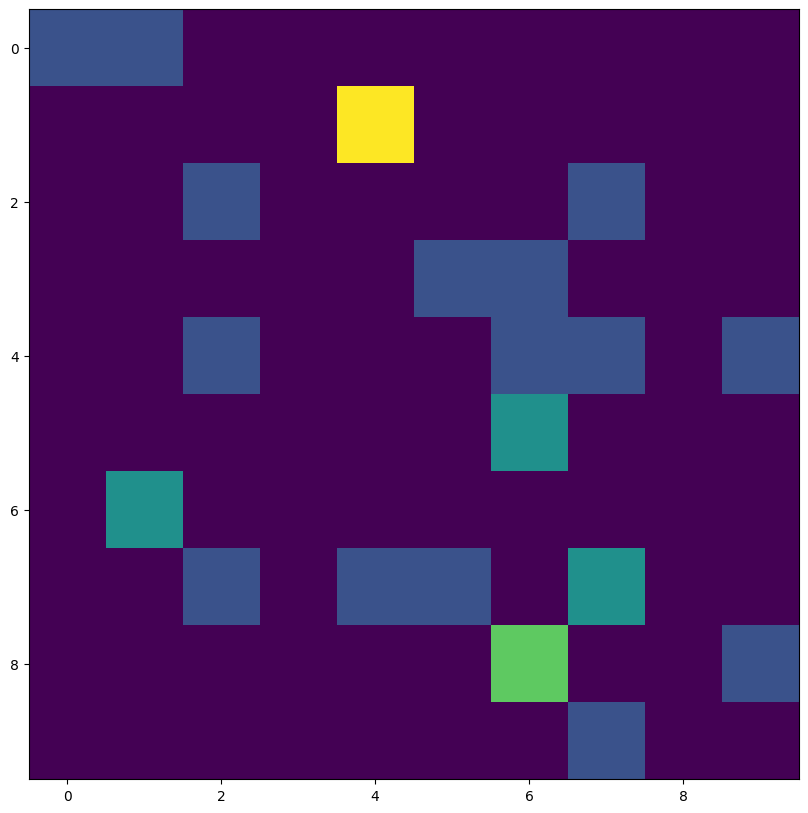

Enemy 1 move: (5, 6)->(6, 6)
Enemy 2 move: (6, 1)->(6, 2)
Enemy 3 move: (7, 7)->(7, 6)


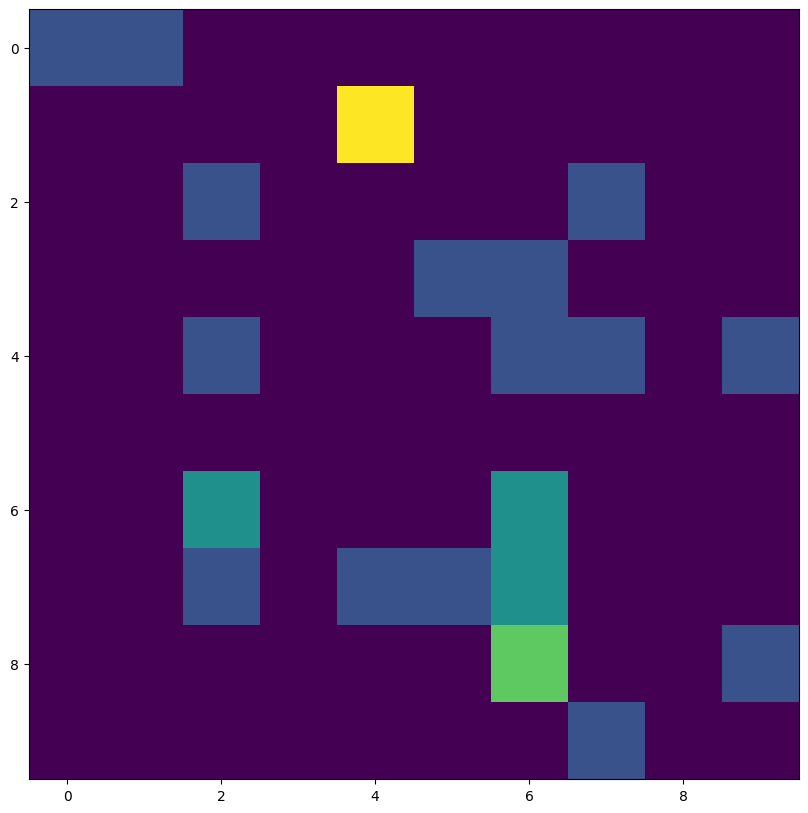

Pacman move: (8, 6)->(8, 5)


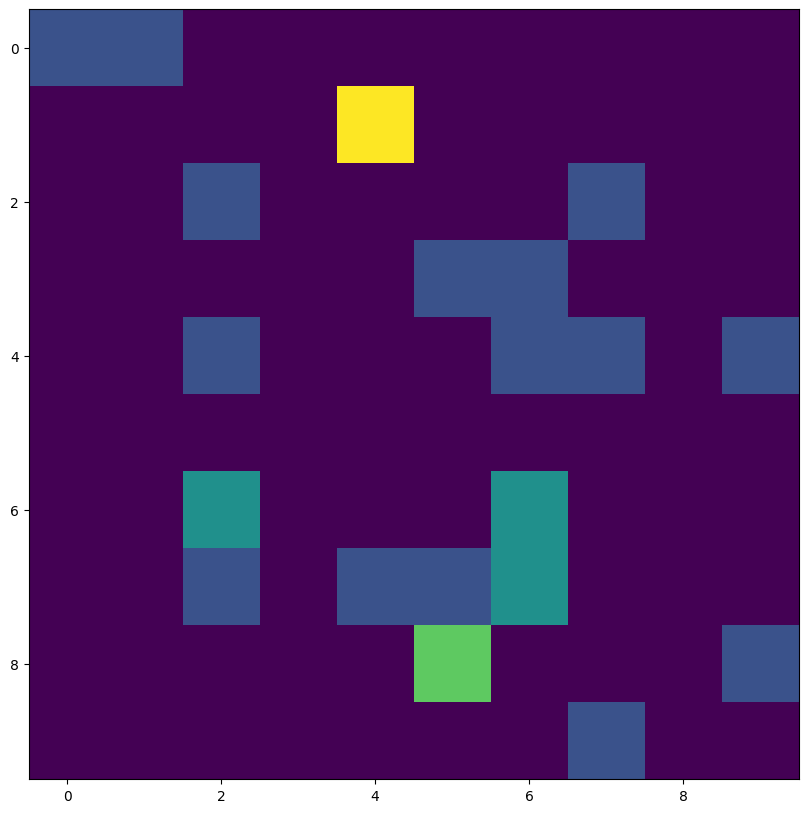

Enemy 1 move: (6, 2)->(6, 3)
Enemy 2 move: (6, 6)->(6, 6)
Enemy 3 move: (7, 6)->(8, 6)


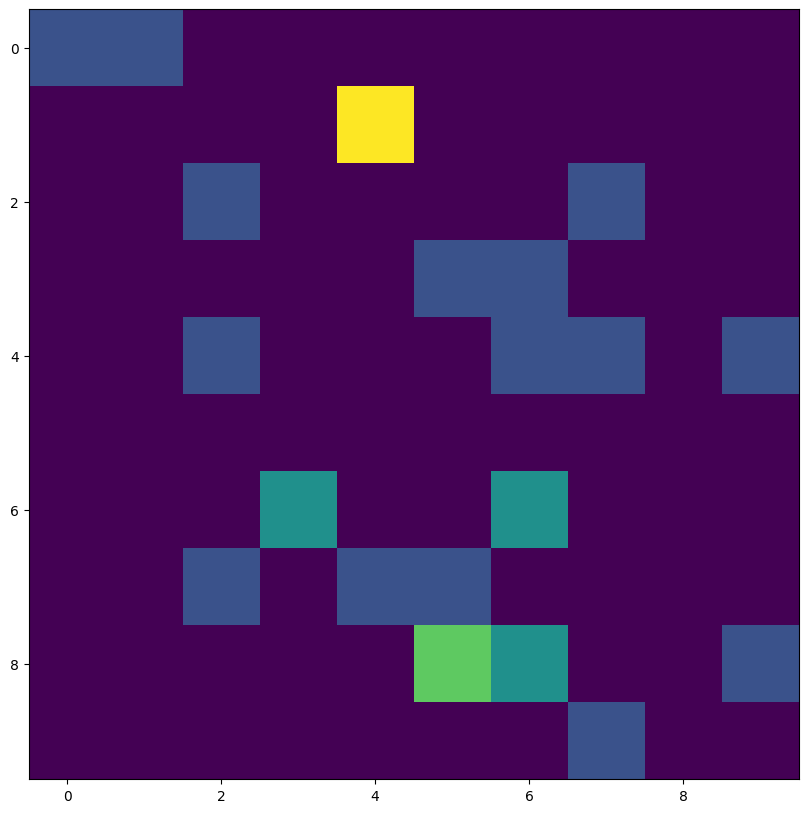

Pacman move: (8, 5)->(8, 4)


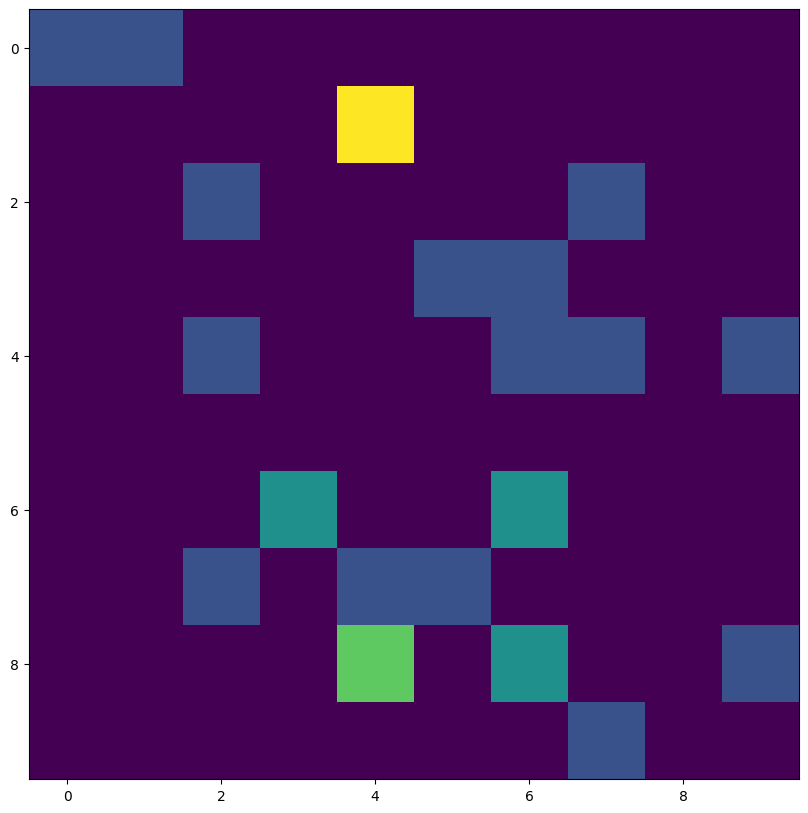

Enemy 1 move: (6, 3)->(7, 3)
Enemy 2 move: (6, 6)->(7, 6)
Enemy 3 move: (8, 6)->(8, 5)


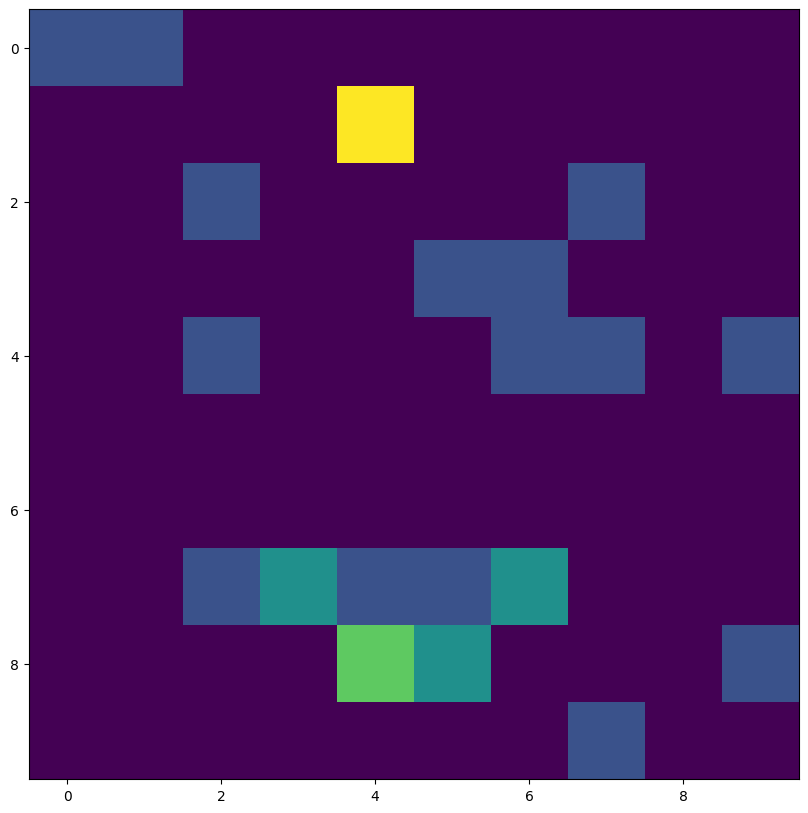

Pacman move: (8, 4)->(8, 3)


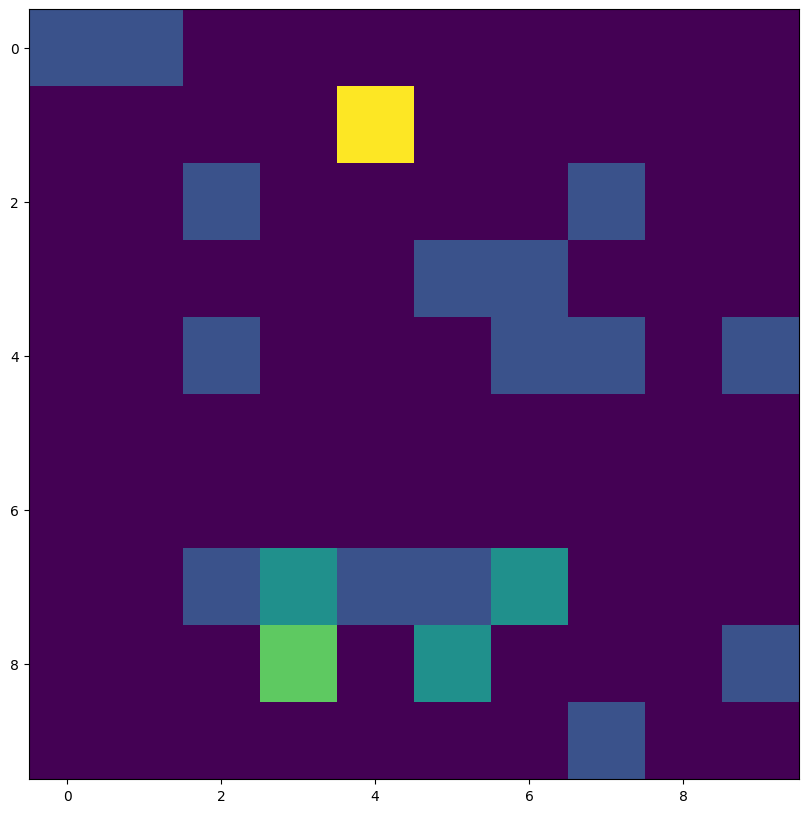

Enemies win.


In [7]:
game2 = Game(10, 10, 15, 3, 2)
game2.play(True)